# RDS HW2 solution

Install the Data Synthesizer library.

In [1]:
!pip install DataSynthesizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def generate_data_A(input_data_file, output_data_size, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['A']
    
    describer = DataDescriber()
    describer.describe_dataset_in_random_mode(input_data_file, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_random_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [4]:
def generate_data_B(input_data_file, output_data_size, epsilon=0.1, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['B']
    
    describer = DataDescriber()
    describer.describe_dataset_in_independent_attribute_mode(input_data_file, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_independent_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [5]:
def generate_data_CD(input_data_file, output_data_size, description_file, epsilon=0.5, k=1, seed=None):
    seed = seed or randint(0, 2**30)
    
    describer = DataDescriber()
    describer.describe_dataset_in_correlated_attribute_mode(input_data_file, k=k, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

def generate_data_C(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['C'], epsilon, k=1, seed=seed)

def generate_data_D(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['D'], epsilon, k=2, seed=seed)

Start with a real dataset __hw_compas__ and a fake dataset __hw_xyz__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [6]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fileid_compas = '1kgSIBkOM9y0nz_l8LI8ze9TAhF5gbb64'    
real_data_file = 'hw_compas.csv'

fileid_fake = '1b_T0SHQUMbVvZueZ6yXlxTKBHctMgM0k'    
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas}) 
downloaded.GetContentFile(real_data_file)  
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake}) 
downloaded.GetContentFile(fake_data_file)  
df_fake = pd.read_csv(fake_data_file)

In [8]:
output_data_size = 10000
epsilon = 0.1

seed = 0  # make the entire notebook reproducible

description_files = {'A': './descrption_A.json', 
                     'B': './descrption_B.json', 
                     'C': './descrption_C.json', 
                     'D': './descrption_D.json'}

set_random_seed(seed)

df_real_A = generate_data_A(real_data_file, output_data_size)
df_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon)
df_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon)
df_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon)

df_fake_A = generate_data_A(fake_data_file, output_data_size)
df_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)

clear_output()

In [9]:
df_fake_A

,parent_1,parent_2,child_1,child_2
0,1,1,2,2
1,2,2,2,1
2,0,1,2,1
3,2,2,2,2
4,0,2,0,2
...,...,...,...,...
9995,2,0,0,0
9996,0,2,0,1
9997,0,0,0,2
9998,2,0,2,2


In [10]:
df_real_C.head()

,sex,age,race,score
0,Female,51.0,African-American,7
1,Male,25.0,Hispanic,6
2,Male,52.0,Caucasian,1
3,Male,21.0,African-American,5
4,Male,49.0,African-American,9


## Part (a)

### Q1

Median, Mean, Min, Max of __age__ and __score__ for each A, B, C and D, compare to the ground truth value in __hw_compas__, present results in a table

In [11]:
# Your code here
import tabulate

# real_data_file -> Real dataset
df_initial_real = pd.read_csv(real_data_file)

initial_stats = df_initial_real.agg({'age': ['median', 'mean', 'min', 'max'], 
                                  'score': ['median', 'mean', 'min', 'max']})


Synthetic_Real_A = df_real_A.agg({'age': ['median', 'mean', 'min', 'max'], 
                                  'score': ['median', 'mean', 'min', 'max']})


Synthetic_Real_B = df_real_B.agg({'age': ['median', 'mean', 'min', 'max'], 
                                  'score': ['median', 'mean', 'min', 'max']})

Synthetic_Real_C = df_real_C.agg({'age': ['median', 'mean', 'min', 'max'], 
                                  'score': ['median', 'mean', 'min', 'max']})

Synthetic_Real_D = df_real_D.agg({'age': ['median', 'mean', 'min', 'max'], 
                                  'score': ['median', 'mean', 'min', 'max']})

print("initial_stats\n")
print(tabulate.tabulate(initial_stats, headers="keys"))
print("\n")

print("Synthetic_Real_A \n")
print(tabulate.tabulate(Synthetic_Real_A, headers="keys"))
print("\n")

print("Synthetic_Real_B\n")
print(tabulate.tabulate(Synthetic_Real_B, headers="keys"))
print("\n")

print("Synthetic_Real_C\n")
print(tabulate.tabulate(Synthetic_Real_C, headers="keys"))
print("\n")

print("Synthetic_Real_D\n")
print(tabulate.tabulate(Synthetic_Real_D, headers="keys"))
print("\n")


initial_stats

            age     score
------  -------  --------
median  32        4
mean    35.1433   4.37127
min     18       -1
max     96       10


Synthetic_Real_A 

             age    score
------  --------  -------
median   51        5
mean     50.1731   4.9392
min       0       -1
max     100       10


Synthetic_Real_B

            age    score
------  -------  -------
median  33        4
mean    35.7354   4.3657
min     18        1
max     76       10


Synthetic_Real_C

            age    score
------  -------  -------
median  36        5
mean    41.5788   4.9487
min     18       -1
max     96       10


Synthetic_Real_D

            age    score
------  -------  -------
median  39         4
mean    44.1532    4.466
min     18        -1
max     96        10




In [12]:
print("Difference between Random mode generated data and Real Dataset \n")
print(tabulate.tabulate(abs(Synthetic_Real_A - initial_stats), headers="keys"))
print("\n")

print("Difference between Independent mode generated data and Real Dataset \n")
print(tabulate.tabulate(abs(Synthetic_Real_B - initial_stats), headers="keys"))
print("\n")

print("Difference between correlated attribute mode ( BND = 1 ) generated data and Real Dataset \n")
print(tabulate.tabulate(abs(Synthetic_Real_C - initial_stats), headers="keys"))
print("\n")

print("Difference between correlated attribute mode ( BND = 2 ) generated data and Real Dataset \n")
print(tabulate.tabulate(abs(Synthetic_Real_D - initial_stats), headers="keys"))
print("\n")

Difference between Random mode generated data and Real Dataset 

            age     score
------  -------  --------
median  19       1
mean    15.0298  0.567932
min     18       0
max      4       0


Difference between Independent mode generated data and Real Dataset 

              age       score
------  ---------  ----------
median   1         0
mean     0.592081  0.00556818
min      0         2
max     20         0


Difference between correlated attribute mode ( BND = 1 ) generated data and Real Dataset 

            age     score
------  -------  --------
median  4        1
mean    6.43548  0.577432
min     0        0
max     0        0


Difference between correlated attribute mode ( BND = 2 ) generated data and Real Dataset 

            age      score
------  -------  ---------
median  7        0
mean    9.00988  0.0947318
min     0        0
max     0        0




[Text(0.5, 0, 'age'),
 Text(0, 0.5, 'frequency'),
 Text(0.5, 1.0, 'Synthetic data distribution - Correlated mode BND=1')]

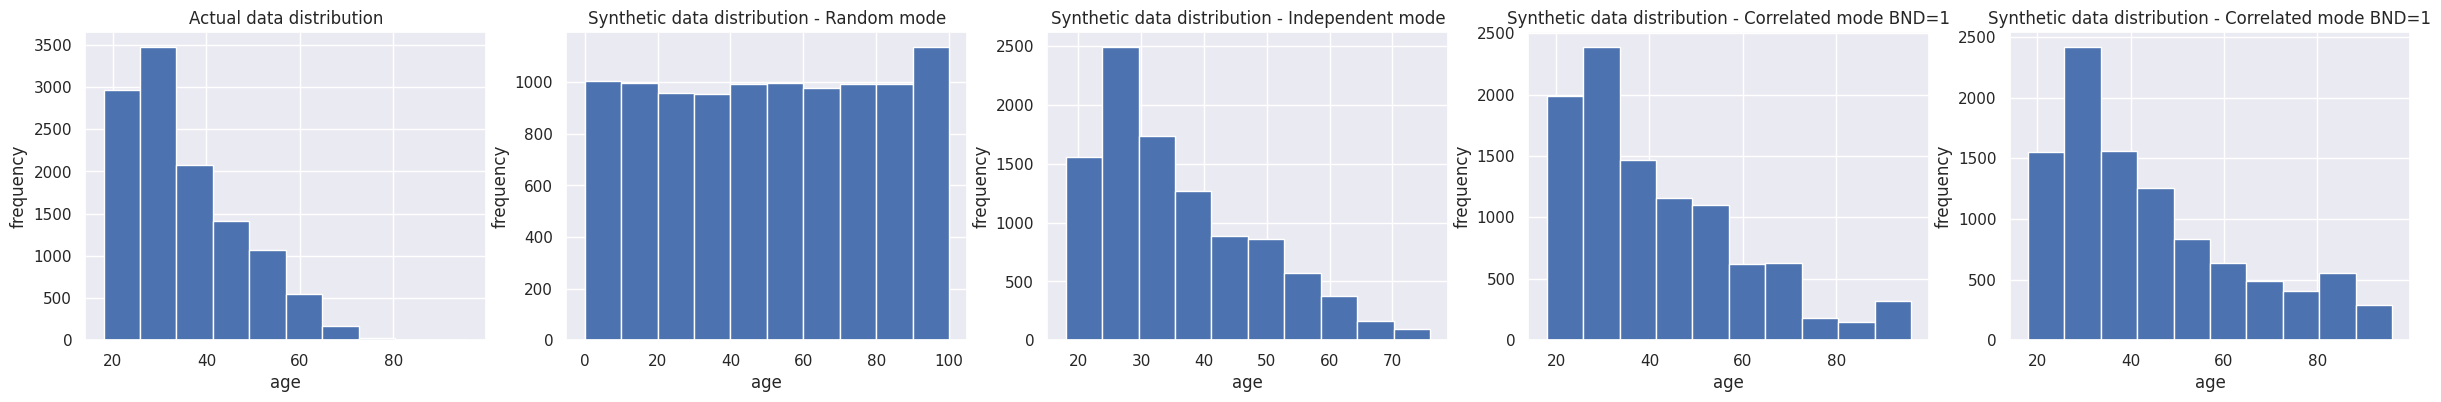

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,5,figsize=(30,4),dpi=100)


ax[0].hist(df_initial_real['age'],bins = 10)
ax[0].set(xlabel='age',ylabel='frequency',title = 'Actual data distribution')
ax[1].hist(df_real_A['age'],bins = 10)
ax[1].set(xlabel='age',ylabel='frequency',title = 'Synthetic data distribution - Random mode')
ax[2].hist(df_real_B['age'],bins = 10)
ax[2].set(xlabel='age',ylabel='frequency',title = 'Synthetic data distribution - Independent mode')
ax[3].hist(df_real_C['age'],bins = 10)
ax[3].set(xlabel='age',ylabel='frequency',title = 'Synthetic data distribution - Correlated mode BND=1')
ax[4].hist(df_real_D['age'],bins = 10)
ax[4].set(xlabel='age',ylabel='frequency',title = 'Synthetic data distribution - Correlated mode BND=1')



[Text(0.5, 0, 'score'),
 Text(0, 0.5, 'frequency'),
 Text(0.5, 1.0, 'Synthetic data distribution - Correlated mode BND=1')]

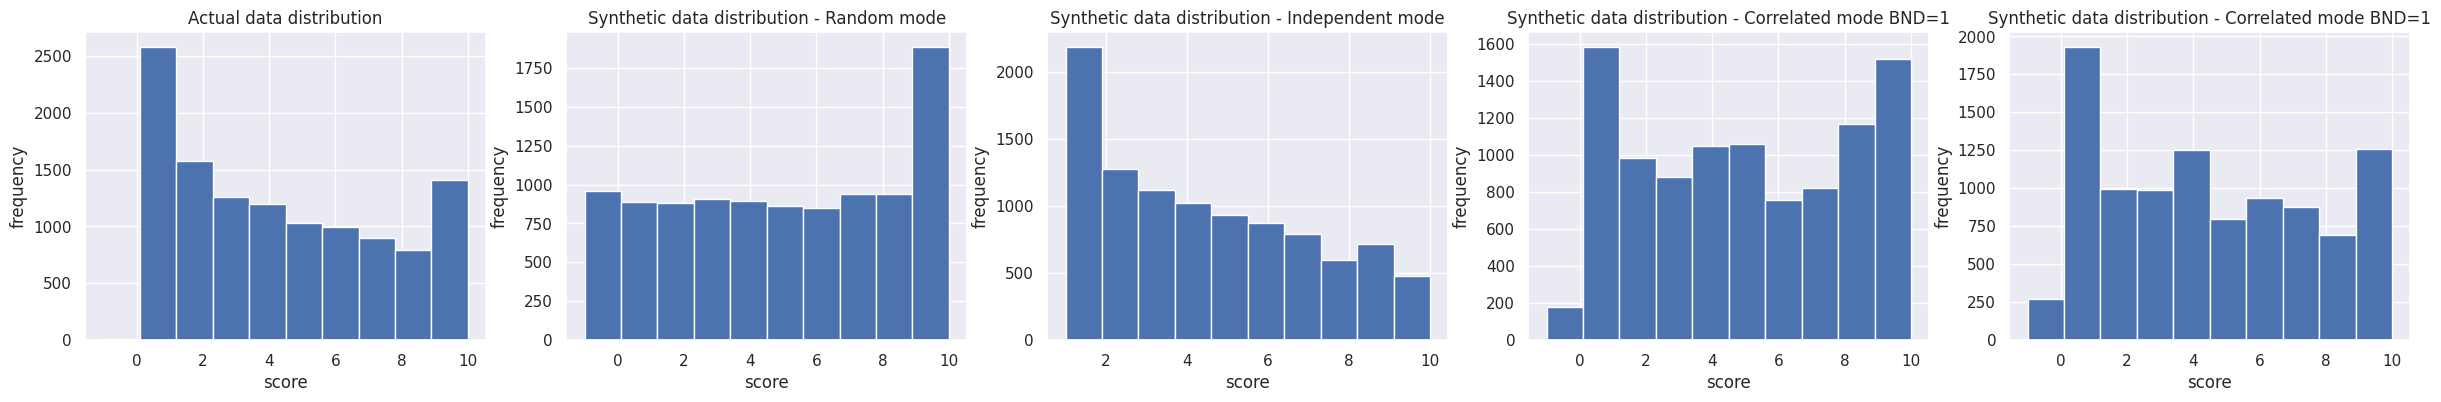

In [14]:
fig, ax = plt.subplots(1,5,figsize=(30,4),dpi=100)


ax[0].hist(df_initial_real['score'],bins = 10)
ax[0].set(xlabel='score',ylabel='frequency',title = 'Actual data distribution')
ax[1].hist(df_real_A['score'],bins = 10)
ax[1].set(xlabel='score',ylabel='frequency',title = 'Synthetic data distribution - Random mode')
ax[2].hist(df_real_B['score'],bins = 10)
ax[2].set(xlabel='score',ylabel='frequency',title = 'Synthetic data distribution - Independent mode')
ax[3].hist(df_real_C['score'],bins = 10)
ax[3].set(xlabel='score',ylabel='frequency',title = 'Synthetic data distribution - Correlated mode BND=1')
ax[4].hist(df_real_D['score'],bins = 10)
ax[4].set(xlabel='score',ylabel='frequency',title = 'Synthetic data distribution - Correlated mode BND=1')


If we compare the mean median difference between synthetic generated data and real data, we see that in independent mode there is minimum difference between synthetic data and real data. While we can say that random mode performs the worst. 

Looking at the age distribution of all the synthetic datasets and comparing it to the real dataset we can say that the Random mode gives the worst results because it gives each value equal probability, while independent mode and correlated modes give quite similar results. Here it can be that the 'age' attribute can be a little or not correlated at all. That is why even after correlation we dont see a lot of improvement. 


Looking at the 'score' distribution of all the synthetic datasets and comparing it to the real dataset we can say that the Random mode gives the worst results because it gives each value equal probability, while independent mode provides the best results with comparable distribution. Here the correlated datasets are not showing good distribution results. This can be because the attribute 'score' is not correlated to any other attribute and therefore treating it as an independent column and generating new data is a better method. 


### Q2

Some more sophisticated statistical measure that’s good for independent attribute mode - __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__. Also show the difference visually, comparing real vs. synthetic

<Axes: title={'center': 'Synthetic data distribution (Sex) - Random mode'}, xlabel='sex', ylabel='count'>

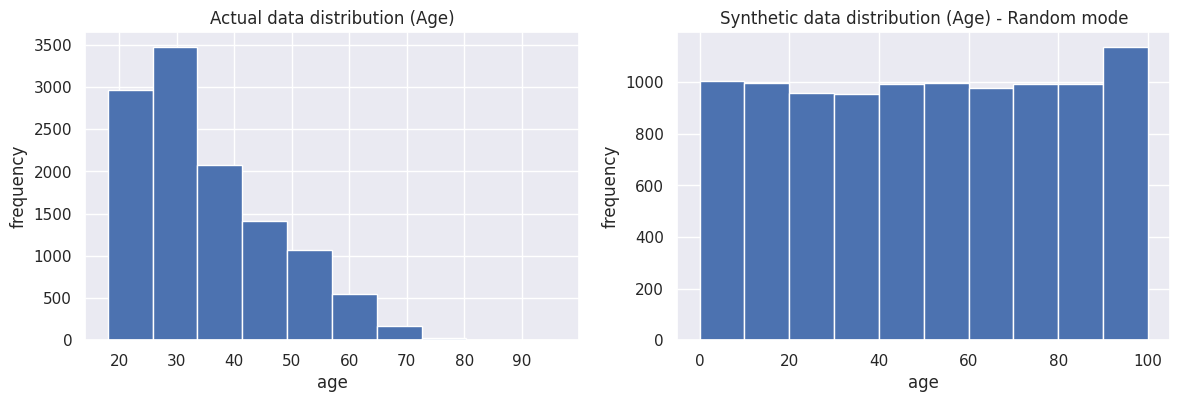

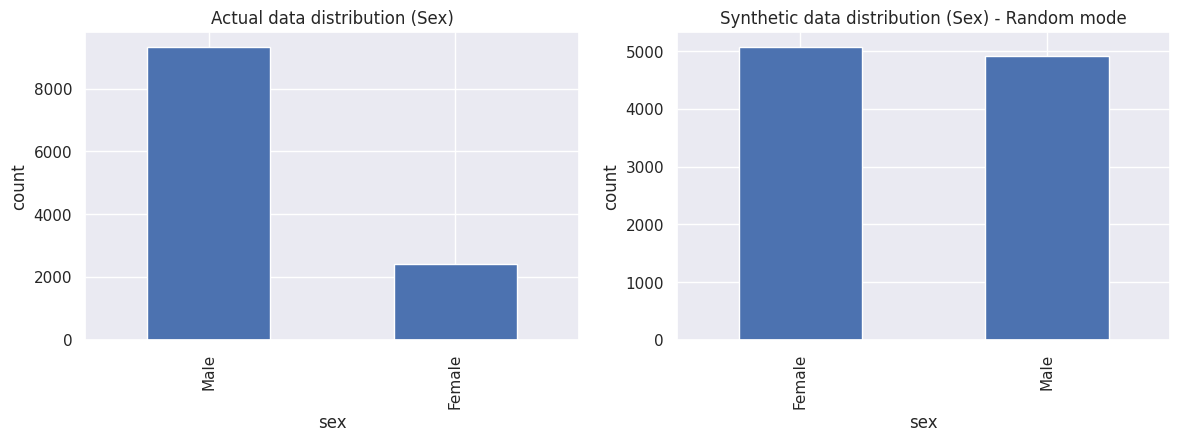

In [15]:
# RANDOM MODE
fig, ax = plt.subplots(1,2,figsize=(14,4),dpi=100)

ax[0].hist(df_initial_real['age'],bins = 10)
ax[0].set(xlabel='age',ylabel='frequency',title = 'Actual data distribution (Age)')
ax[1].hist(df_real_A['age'],bins = 10)
ax[1].set(xlabel='age',ylabel='frequency',title = 'Synthetic data distribution (Age) - Random mode')

fig, ax = plt.subplots(1,2,figsize=(14,4),dpi=100)

df_initial_real['sex'].value_counts().plot(kind='bar',ax=ax[0],title='Actual data distribution (Sex)',xlabel='sex',ylabel='count')
df_real_A['sex'].value_counts().plot(kind='bar',ax=ax[1],title='Synthetic data distribution (Sex) - Random mode',xlabel='sex',ylabel='count')




<Axes: title={'center': 'Synthetic data distribution (Sex) - Independent mode'}, xlabel='sex', ylabel='count'>

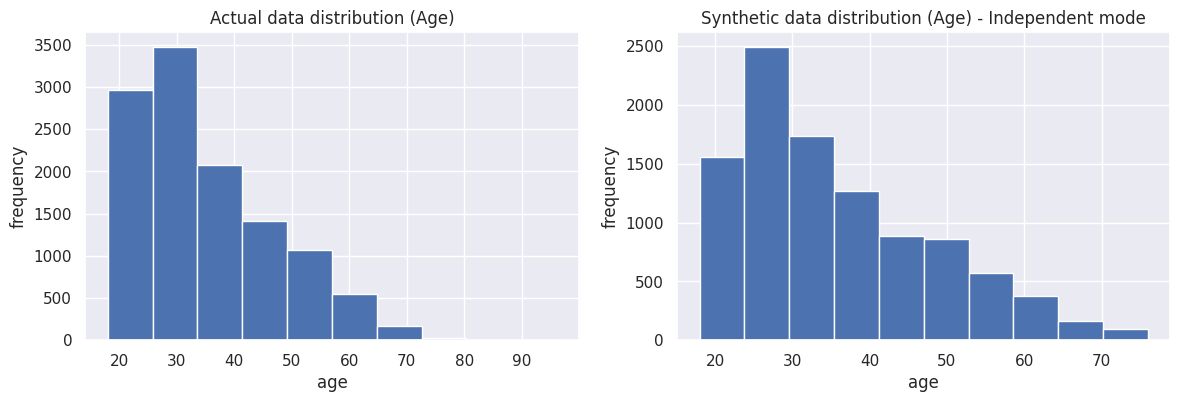

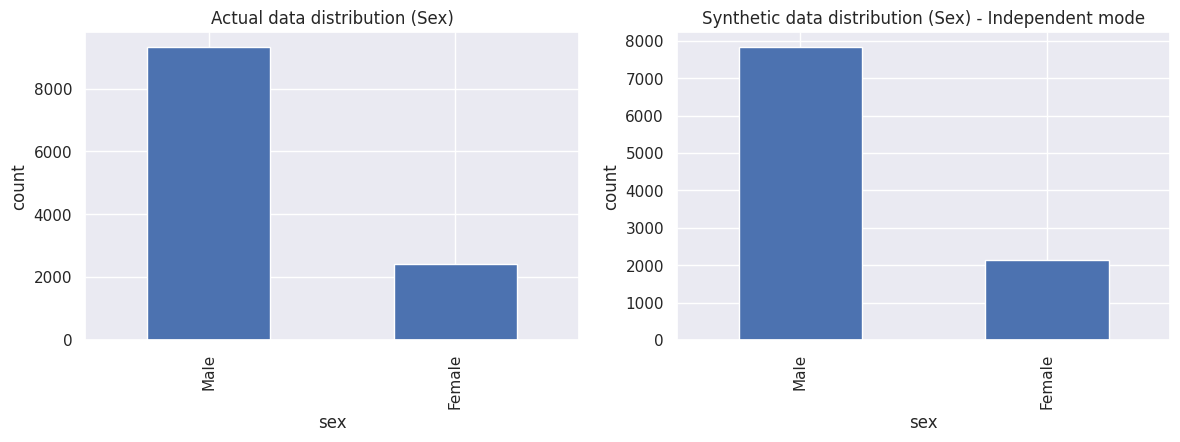

In [16]:
# INDEPENDENT MODE

fig, ax = plt.subplots(1,2,figsize=(14,4),dpi=100)

ax[0].hist(df_initial_real['age'],bins = 10)
ax[0].set(xlabel='age',ylabel='frequency',title = 'Actual data distribution (Age)')
ax[1].hist(df_real_B['age'],bins = 10)
ax[1].set(xlabel='age',ylabel='frequency',title = 'Synthetic data distribution (Age) - Independent mode')

fig, ax = plt.subplots(1,2,figsize=(14,4),dpi=100)

df_initial_real['sex'].value_counts().plot(kind='bar',ax=ax[0],title='Actual data distribution (Sex)',xlabel='sex',ylabel='count')
df_real_B['sex'].value_counts().plot(kind='bar',ax=ax[1],title='Synthetic data distribution (Sex) - Independent mode',xlabel='sex',ylabel='count')



HERE WE WILL EXPLAIN THE ABOVE OBSERVATIONS.......

#### Two-sample Kolmogorov–Smirnov test for continous attributes

In [17]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

#### KL-divergence for categorical attributes

In [18]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [19]:
#
print("KS Test : Difference in probability distributions over Age Between hw_compas vs. in privacy-preserving synthetic data\n")

print("Random mode\n")
val = ks_test(df_initial_real, df_real_A, 'age')
print("ks_test score:",val,"\n")

print("Independent mode\n")
val = ks_test(df_initial_real, df_real_B, 'age')
print("ks_test score:",val,"\n")

print("K-S Test : Difference in probability distributions over sex Between hw_compas vs. in privacy-preserving synthetic data\n")
print("Random mode\n")
val = ks_test(df_initial_real, df_real_A, 'sex')
print("ks_test score:",val,"\n")

print("Independent mode \n")
val = ks_test(df_initial_real, df_real_B, 'sex')
print("ks_test score:",val,"\n")

KS Test : Difference in probability distributions over Age Between hw_compas vs. in privacy-preserving synthetic data

Random mode

ks_test score: 0.3735091775112699 

Independent mode

ks_test score: 0.026252445351705345 

K-S Test : Difference in probability distributions over sex Between hw_compas vs. in privacy-preserving synthetic data

Random mode

ks_test score: 0.30208012248022453 

Independent mode 

ks_test score: 0.00908012248022455 



In [20]:
print("K-L Test : Difference in probability distributions over sex Between hw_compas vs. in privacy-preserving synthetic data\n")
print("Random mode\n")
val = kl_test(df_initial_real, df_real_A, 'sex')
print("KL test score:",val,"\n")

print("Independent mode \n")
val = kl_test(df_initial_real, df_real_B, 'sex')
print("KL test score:",val,"\n")

K-L Test : Difference in probability distributions over sex Between hw_compas vs. in privacy-preserving synthetic data

Random mode

KL test score: 0.22319792405369002 

Independent mode 

KL test score: 0.0002494300869420041 



 Here we will discuss the relative difference in performance under A and B in your report.

### Q3

some more sophisticated statistical measure that’s good for correlated attribute mode, and will be better with k=2 (case D) than with k=1 (case C), __some distance over pairwise correlation coefficients? Also show the difference visually, comparing results on real vs. synthetic datasets__.

In [21]:
# Use pairwise_attributes_mutual_information function. 
# For function parameters, refer to https://github.com/DataResponsibly/DataSynthesizer/blob/master/DataSynthesizer/lib/utils.py#L31
# Your code here

from sklearn.metrics import normalized_mutual_info_score


df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)


================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_1
Adding attribute parent_1
Adding attribute child_2
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_1
Adding attribute child_2
Adding attribute parent_1
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


#PAIRWISE MUTUAL INFORMATION MATRIX BY HEATMAP 

#CASE-C : CORRELATED ATTRIBUTE MODE WITH K=1

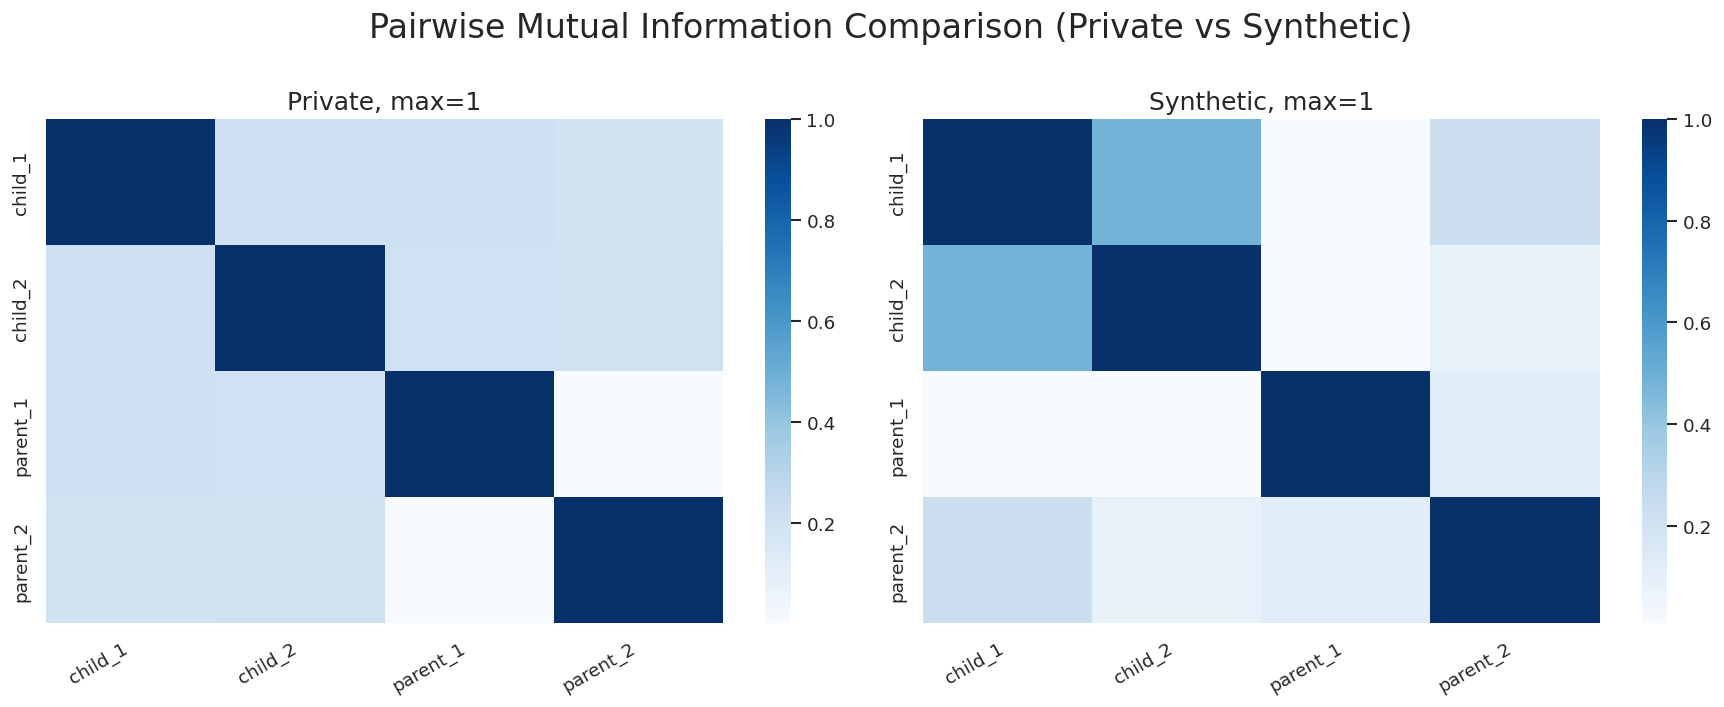

In [22]:
attribute_description = read_json_file(description_files['C'])['attribute_description']
ModelInspector(df_fake, 
               df_fake_C, 
               attribute_description).mutual_information_heatmap()


#CASE-D : CORRELATED ATTRIBUTE MODE WITH K=2

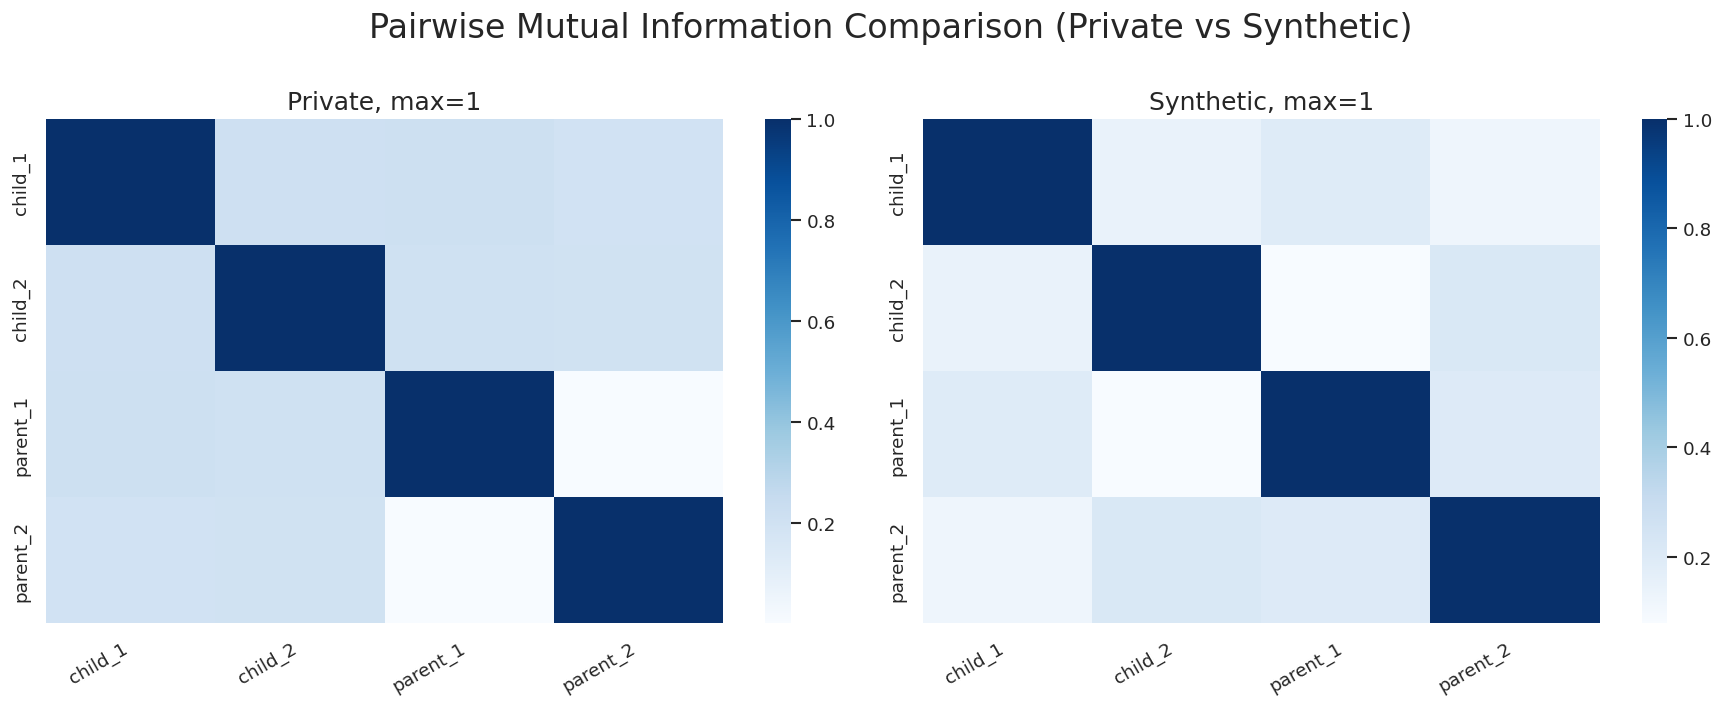

In [23]:
attribute_description = read_json_file(description_files['D'])['attribute_description']
ModelInspector(df_fake, 
               df_fake_D, 
               attribute_description).mutual_information_heatmap()

In [24]:
# Use can sns.heatmap for pairwise mutual information
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.heatmap.html
# Your code here

## Part (b)

Study the variability in accuracy of answers to Q1 and Q2 for A, B and C: fix epsilon = 0.1, generate __10__ synthetic databases (by specifying different seeds).  Plot accuracy as a box-and-whiskers plot.  

Text(0.5, 1.0, 'max C')

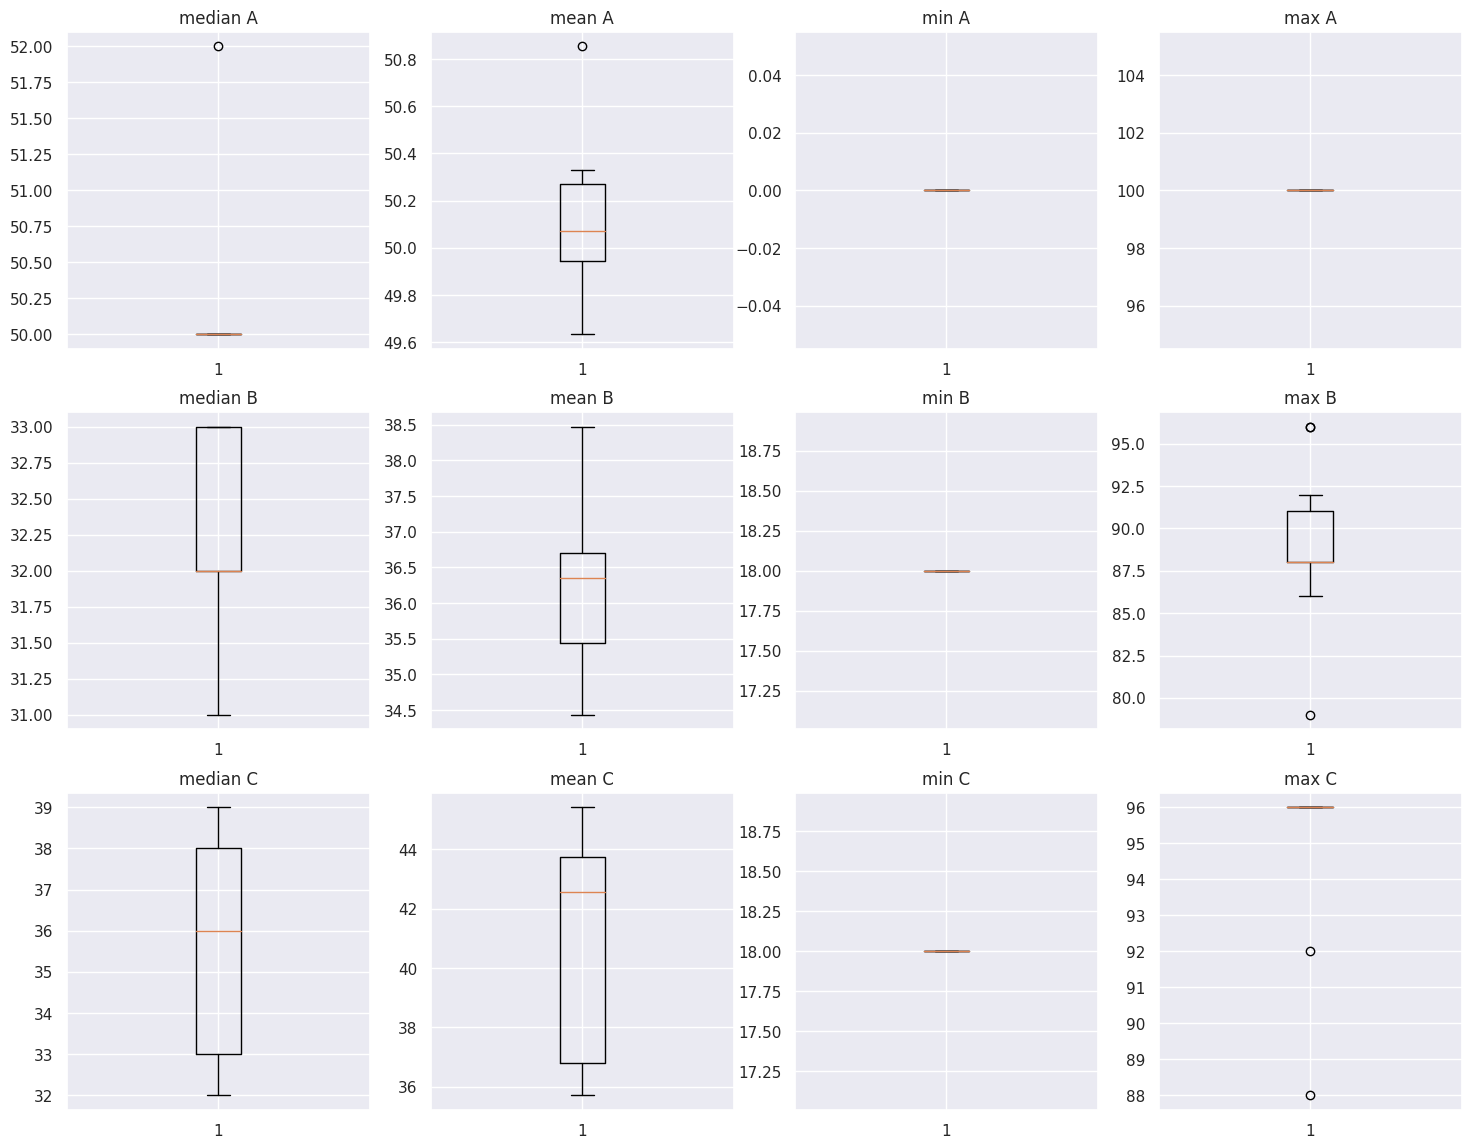

In [25]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html
# Your code here
import numpy as np
epsilon = 0.1
from google.colab import output

#A

seeds_arr = [0,1,2,3,4,5,6,7,8,9]
median_A = []
mean_A = []
min_A = []
max_A = []
median_B = []
mean_B = []
min_B = []
max_B = []
median_C = []
mean_C = []
min_C = []
max_C = []


for seed in seeds_arr:
  data_A_synthetic = generate_data_A(real_data_file,output_data_size,seed=seed)
  #output_A = data_A_synthetic.agg({'age': ['median', 'mean', 'min', 'max']})
  median_A.append(np.median(data_A_synthetic['age']))
  mean_A.append(np.mean(data_A_synthetic['age']))
  min_A.append(np.min(data_A_synthetic['age']))
  max_A.append(np.max(data_A_synthetic['age']))
  # print(np.median(data_A_synthetic['age']))
  # print(np.mean(data_A_synthetic['age']))
  # print(np.min(data_A_synthetic['age']))
  # print(np.max(data_A_synthetic['age']))

  data_B_synthetic = generate_data_B(real_data_file,output_data_size,epsilon=0.1,seed=seed)
  median_B.append(np.median(data_B_synthetic['age']))
  mean_B.append(np.mean(data_B_synthetic['age']))
  min_B.append(np.min(data_B_synthetic['age']))
  max_B.append(np.max(data_B_synthetic['age']))

  data_C_synthetic = generate_data_C(real_data_file,output_data_size,epsilon=0.1,seed=seed)
  median_C.append(np.median(data_C_synthetic['age']))
  mean_C.append(np.mean(data_C_synthetic['age']))
  min_C.append(np.min(data_C_synthetic['age']))
  max_C.append(np.max(data_C_synthetic['age']))

output.clear()

fig, ax = plt.subplots(3,4,figsize=(18,14),dpi=100)
ax[0,0].boxplot(median_A)
ax[0,0].set_title("median A")
ax[0,1].boxplot(mean_A)
ax[0,1].set_title("mean A")
ax[0,2].boxplot(min_A)
ax[0,2].set_title("min A")
ax[0,3].boxplot(max_A)
ax[0,3].set_title("max A")
ax[1,0].boxplot(median_B)
ax[1,0].set_title("median B")
ax[1,1].boxplot(mean_B)
ax[1,1].set_title("mean B")
ax[1,2].boxplot(min_B)
ax[1,2].set_title("min B")
ax[1,3].boxplot(max_B)
ax[1,3].set_title("max B")
ax[2,0].boxplot(median_C)
ax[2,0].set_title("median C")
ax[2,1].boxplot(mean_C)
ax[2,1].set_title("mean C")
ax[2,2].boxplot(min_C)
ax[2,2].set_title("min C")
ax[2,3].boxplot(max_C)
ax[2,3].set_title("max C")


In [26]:
real_data_median = np.median(df_real['age'])
real_data_mean = np.mean(df_real['age'])
real_data_min = np.min(df_real['age'])
real_data_max = np.max(df_real['age'])

print("Real data Median: ",real_data_median)

print("Real data Mean: ",real_data_mean)

print("Real data Min: ",real_data_min)

print("Real data Max: ",real_data_max)

Real data Median:  32.0
Real data Mean:  35.14331887386238
Real data Min:  18
Real data Max:  96


## Part (c)

Study how accuracy of Q3 changes for case **C**, as you vary __epsilon__ = [0.01, 0.02, ..., 0.1].

In [27]:
# Your code here
from scipy.stats import entropy

def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [28]:
epsilon_arr = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
seeds_arr = [100,101,102,103,104,105,106,107]

#df_real
kl_score_B_arr = []
kl_score_C_arr = []
kl_score_D_arr = []

for e in epsilon_arr:
  kl_score_B = []
  kl_score_C = []
  kl_score_D = [] 
  for seed in seeds_arr:
    data_B_synthetic = generate_data_B(real_data_file,output_data_size,seed=seed,epsilon=e)
    kl_score_B.append(kl_test(df_real,data_B_synthetic,'race'))
    data_C_synthetic = generate_data_C(real_data_file,output_data_size,seed=seed,epsilon=e)
    kl_score_C.append(kl_test(df_real,data_C_synthetic,'race'))
    data_D_synthetic = generate_data_D(real_data_file,output_data_size,seed=seed,epsilon=e)
    kl_score_D.append(kl_test(df_real,data_D_synthetic,'race'))
  kl_score_B_arr.append(kl_score_B)  
  kl_score_C_arr.append(kl_score_C) 
  kl_score_D_arr.append(kl_score_D)   

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute sex
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

Adding attribute age
Adding attribute sex
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute race
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute age
Adding attribute score
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):
/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute sex
Adding attribute score
Adding attribute race
========================== BN constructed ==========================


/usr/local/lib/python3.9/dist-packages/DataSynthesizer/lib/PrivBayes.py:275: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for parents_instance, stats_sub in stats.groupby(parents):


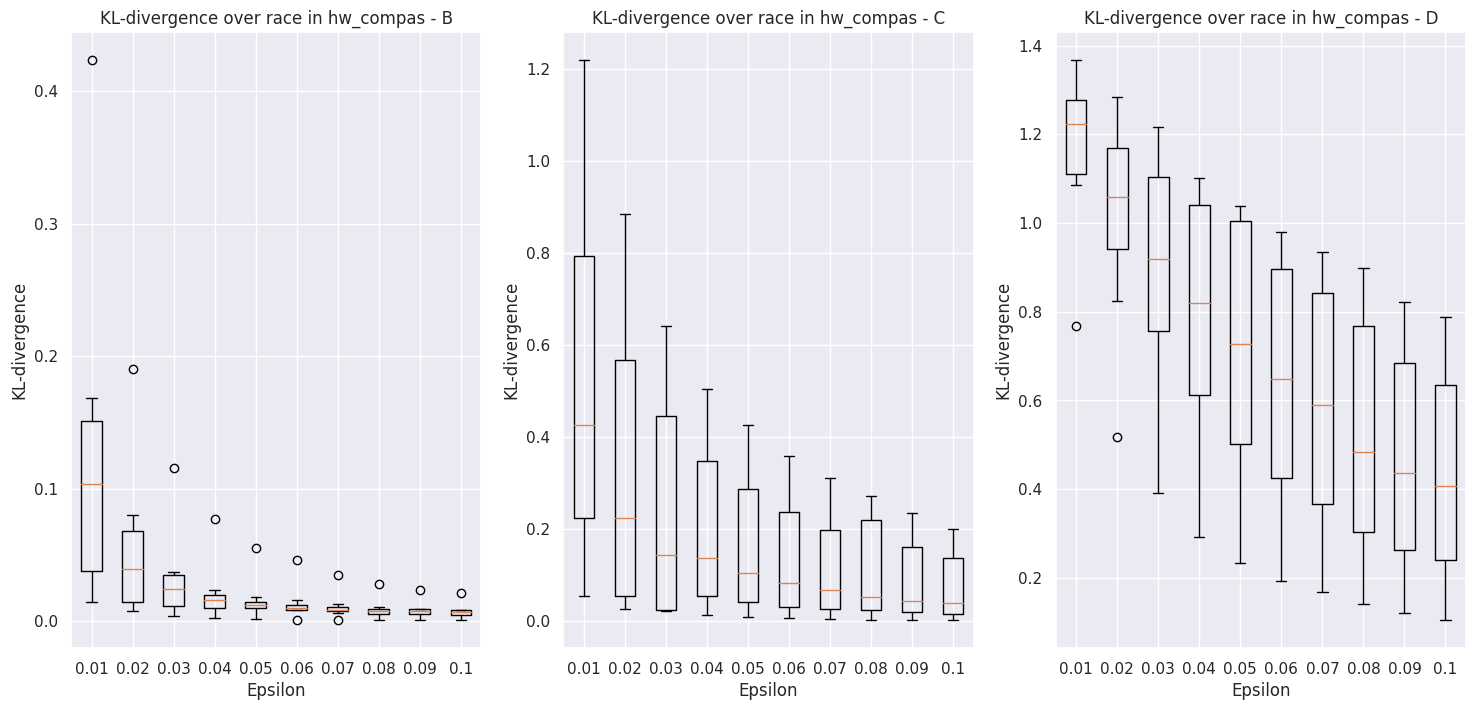

In [31]:
fig, ax = plt.subplots(1,3,figsize=(18,8),dpi=100)
ax[0].boxplot(kl_score_B_arr, labels=epsilon_arr)
ax[0].set_xlabel('Epsilon')
ax[0].set_ylabel('KL-divergence')
ax[0].set_title('KL-divergence over race in hw_compas - B')
ax[1].boxplot(kl_score_C_arr, labels=epsilon_arr)
ax[1].set_xlabel('Epsilon')
ax[1].set_ylabel('KL-divergence')
ax[1].set_title('KL-divergence over race in hw_compas - C')
ax[2].boxplot(kl_score_D_arr, labels=epsilon_arr)
ax[2].set_xlabel('Epsilon')
ax[2].set_ylabel('KL-divergence')
ax[2].set_title('KL-divergence over race in hw_compas - D')
plt.show()

In [32]:
df_real

,sex,age,race,score
0,Male,69,Other,1
1,Male,31,Caucasian,5
2,Male,34,African-American,3
3,Male,24,African-American,4
4,Male,23,African-American,8
...,...,...,...,...
11752,Male,47,Other,3
11753,Male,22,Caucasian,7
11754,Male,35,Other,4
11755,Male,29,Caucasian,3


In [33]:
df_fake

,parent_1,parent_2,child_1,child_2
0,0,2,2,0
1,2,2,2,2
2,2,2,2,2
3,0,0,0,0
4,1,1,1,1
...,...,...,...,...
995,2,1,2,2
996,1,1,1,1
997,2,2,2,2
998,0,2,2,2


In [34]:
from sklearn.metrics import normalized_mutual_info_score


def aggregate_mutual_information(dataset_1,dataset_2):
  aggregate_difference = 0
  column_names_d1 = list(dataset_1.columns)
  column_names_d2 = list(dataset_2.columns)

  for name1 in column_names_d1:
    for name2 in column_names_d1:
      dataset_1_score_sex = normalized_mutual_info_score(dataset_1[name1],dataset_1[name2],average_method='arithmetic')
      dataset_2_score_sex = normalized_mutual_info_score(dataset_2[name1],dataset_2[name2],average_method='arithmetic')
      aggregate_difference = aggregate_difference + abs(dataset_1_score_sex - dataset_2_score_sex)

  return aggregate_difference
  


In [35]:
from sklearn.metrics import normalized_mutual_info_score

ep_arr = [0.0001,0.001,0.01,0.1,1,10,100]
seed_arr = [100,101,102,103,104,105,106,107,108]

# normalized_mutual_info_score

results_B_compass_arr = []
results_C_compass_arr = []
results_D_compass_arr = []
results_B_fake_arr = []
results_C_fake_arr = []
results_D_fake_arr = []

for e in ep_arr:
  results_B_compass = []
  results_C_compass = []
  results_D_compass = []
  results_B_fake = []
  results_C_fake = []
  results_D_fake = []
  for seed in seed_arr:
    data_B_synthetic = generate_data_B(real_data_file,output_data_size,seed=seed,epsilon=e)
    results_B_compass.append(aggregate_mutual_information(df_real,data_B_synthetic))

    data_C_synthetic = generate_data_C(real_data_file,output_data_size,seed=seed,epsilon=e)
    results_C_compass.append(aggregate_mutual_information(df_real,data_C_synthetic))

    data_D_synthetic = generate_data_D(real_data_file,output_data_size,seed=seed,epsilon=e)
    results_D_compass.append(aggregate_mutual_information(df_real,data_D_synthetic))

    data_B_synthetic_fake = generate_data_B(fake_data_file, output_data_size, epsilon=e,seed=seed)
    results_B_fake.append(aggregate_mutual_information(df_fake,data_B_synthetic_fake))

    data_C_synthetic_fake = generate_data_C(fake_data_file, output_data_size, epsilon=e,seed=seed)
    results_C_fake.append(aggregate_mutual_information(df_fake,data_C_synthetic_fake))

    data_D_synthetic_fake = generate_data_D(fake_data_file, output_data_size, epsilon=e,seed=seed)
    results_D_fake.append(aggregate_mutual_information(df_fake,data_D_synthetic_fake))

  #COMPASS
  results_B_compass_arr.append(results_B_compass)
  results_C_compass_arr.append(results_C_compass)
  results_D_compass_arr.append(results_D_compass)

  #FAKE
  results_B_fake_arr.append(results_B_fake)
  results_C_fake_arr.append(results_C_fake)
  results_D_fake_arr.append(results_D_fake)

output.clear()

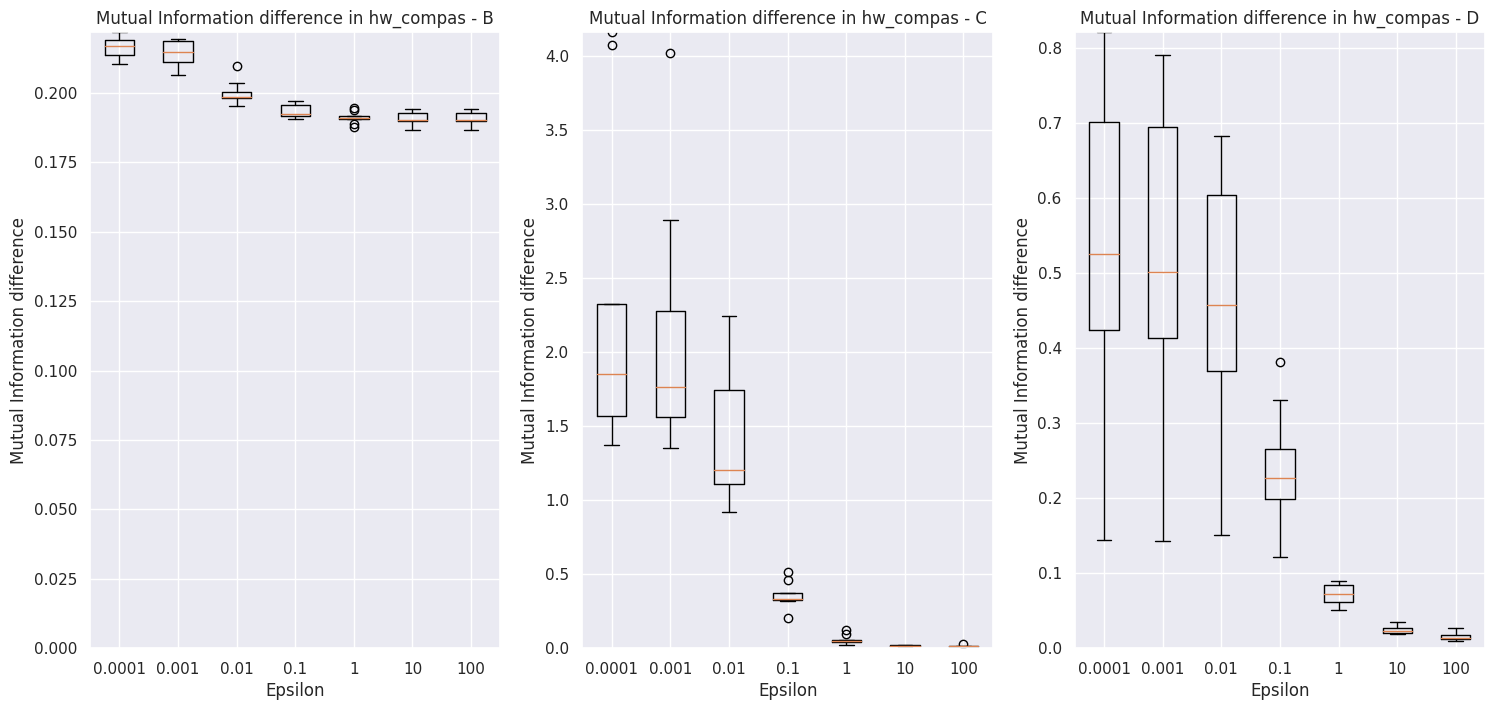

In [38]:
fig , ax = plt.subplots(1,3,figsize=(18,8),dpi=100)

ax[0].boxplot(results_B_compass_arr,labels = ep_arr )
ymin = 0
ymax = np.max(results_B_compass_arr)
ax[0].set_ylim([ymin, ymax])
ax[0].set_xlabel('Epsilon')
ax[0].set_ylabel('Mutual Information difference')
ax[0].set_title('Mutual Information difference in hw_compas - B')

ax[1].boxplot(results_C_compass_arr,labels = ep_arr)
ymin = 0
ymax = np.max(results_C_compass_arr)
ax[1].set_ylim([ymin, ymax])
ax[1].set_xlabel('Epsilon')
ax[1].set_ylabel('Mutual Information difference')
ax[1].set_title('Mutual Information difference in hw_compas - C')

ax[2].boxplot(results_D_compass_arr,labels = ep_arr)
ymin = 0
ymax = np.max(results_D_compass_arr)
ax[2].set_ylim([ymin, ymax])
ax[2].set_xlabel('Epsilon')
ax[2].set_ylabel('Mutual Information difference')
ax[2].set_title('Mutual Information difference in hw_compas - D')
plt.show()

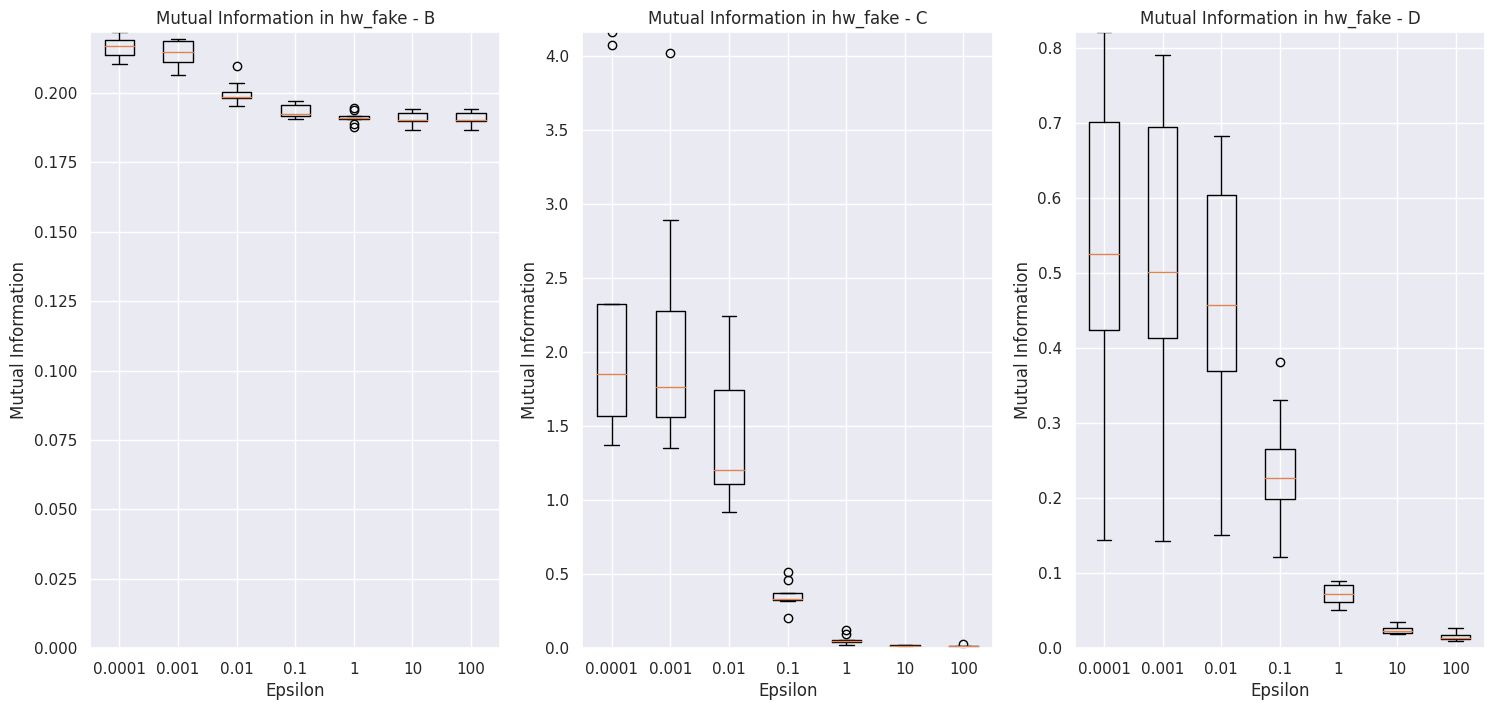

In [39]:
fig , ax = plt.subplots(1,3,figsize=(18,8),dpi=100)

ax[0].boxplot(results_B_compass_arr,labels = ep_arr )
ymin = 0
ymax = np.max(results_B_compass_arr)
ax[0].set_ylim([ymin, ymax])
ax[0].set_xlabel('Epsilon')
ax[0].set_ylabel('Mutual Information')
ax[0].set_title('Mutual Information in hw_fake - B')

ax[1].boxplot(results_C_compass_arr,labels = ep_arr)
ymin = 0
ymax = np.max(results_C_compass_arr)
ax[1].set_ylim([ymin, ymax])
ax[1].set_xlabel('Epsilon')
ax[1].set_ylabel('Mutual Information')
ax[1].set_title('Mutual Information in hw_fake - C')

ax[2].boxplot(results_D_compass_arr,labels = ep_arr)
ymin = 0
ymax = np.max(results_D_compass_arr)
ax[2].set_ylim([ymin, ymax])
ax[2].set_xlabel('Epsilon')
ax[2].set_ylabel('Mutual Information')
ax[2].set_title('Mutual Information in hw_fake - D')
plt.show()

## Part (d)

Create and inspect differentially privаte spanning tree. There is no need to write your own code for this part, but what you write in the report should demonstrate a nuanced understanding of how the structures differ between the two approaches (DataSynthesizer and MST).

In [53]:
# Run and then ignore this cell, installing MST
!git clone https://github.com/ryan112358/private-pgm.git
%cd private-pgm
! pip install -r requirements.txt
! python setup.py install
import os, sys
sys.path.append(os.getcwd())
!git clone https://github.com/lurosenb/host_mst_wrapper
sys.path.insert(1, "/content/private-pgm/src")
from host_mst_wrapper.mst.mst import MSTSynthesizer

Cloning into 'private-pgm'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 563 (delta 67), reused 65 (delta 50), pack-reused 468
Receiving objects: 100% (563/563), 2.15 MiB | 2.27 MiB/s, done.
Resolving deltas: 100% (269/269), done.
/content/private-pgm/private-pgm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
running install
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating src/private_pgm.egg-info
writing src/private_pgm.egg-i

In [54]:
# Here we have to convert all the data from hw_compas to categorical numerical,
# so that MST can process it.
df_real['sex'] = df_real['sex'].astype('category')
df_real['race'] = df_real['race'].astype('category')
df_real['score'] = df_real['score'].astype('category')
categorical = df_real.select_dtypes(['category']).columns
df_real[categorical] = df_real[categorical].apply(lambda x: x.cat.codes)

In [66]:
df_fake['parent_1'] = df_fake['parent_1'].astype('category')
df_fake['parent_2'] = df_fake['parent_2'].astype('category')
df_fake['child_1'] = df_fake['child_1'].astype('category')
df_fake['child_2'] = df_fake['child_2'].astype('category')

In [55]:
df_real

,sex,age,race,score
0,1,69,5,1
1,1,31,2,5
2,1,34,0,3
3,1,24,0,4
4,1,23,0,8
...,...,...,...,...
11752,1,47,5,3
11753,1,22,2,7
11754,1,35,5,4
11755,1,29,2,3


Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'age'), ('age', 'score'), ('race', 'score')]


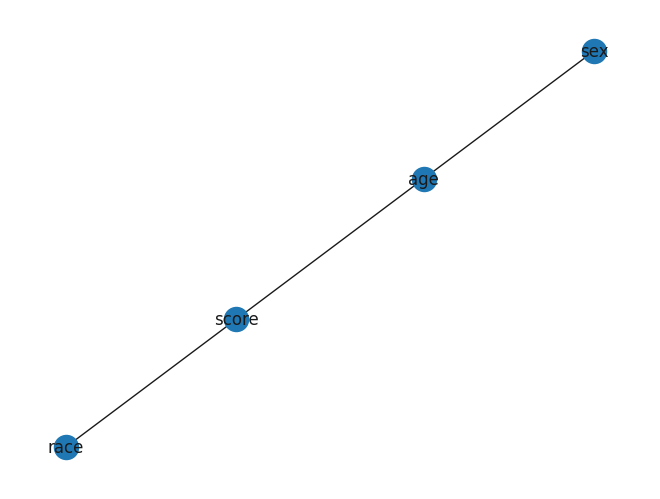

In [45]:
synth = MSTSynthesizer(epsilon=0.1, domain_path="host_mst_wrapper/mst/compas-domain.json")
synth.fit(df_real)
synth.display_MST_graph()

## Part (e)
### 1. KL Divergence for MST
Study how KL Divergence compares on hw_compas for MST compared to dataset **D** (df_real_D), as you vary __epsilon__ = [0.1, 0.2, ..., 1]. You only need to do this for **5 datasets** per epsilon this time (i.e., run 5 iterations per epsilon). Expect each MST run to take ~15-20 seconds.

You can fit the MST synthesizer using the same code as above for visualizing. Once fit, you can produce a synthetic dataset by simply using the following method:

`mst_fake_data = synth.sample(samples=10000)`

After running this command, `mst_fake_data` will be a pandas dataframe with 10000 rows and with the same columns as whatever dataframe MST was fit on! 

In [74]:
epsilons_mst_kl = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
iters = 5
# Your code here
kl_div_scores = [] 
for epsilon in epsilons_mst_kl:
  kl_score_arr = []
  synth = MSTSynthesizer(epsilon=epsilon, domain_path="host_mst_wrapper/mst/compas-domain.json")
  for i in range(iters):
    synth.fit(df_real)
    mst_fake_data = synth.sample(samples=10000)
    kl_score = kl_test(df_real_D,mst_fake_data,'race')
    kl_score_arr.append(kl_score)
  kl_div_scores.append(kl_score_arr)


Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'score'), ('sex', 'race'), ('sex', 'age')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'age'), ('age', 'score'), ('race', 'score')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'race'), ('sex', 'age'), ('race', 'score')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'age'), ('age', 'score'), ('age', 'race')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'race'), ('sex', 'score'), ('age', 'race')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'score'), ('sex', 'age'), ('race', 'score')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score']

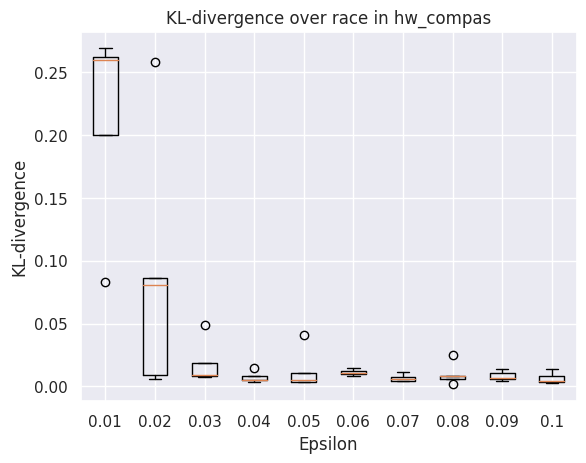

In [78]:
# Plot the distribution of KL-divergence scores
fig, ax = plt.subplots()
ax.boxplot(kl_div_scores, labels=epsilons_mst_kl)
ax.set_xlabel('Epsilon')
ax.set_ylabel('KL-divergence')
ax.set_title('KL-divergence over race in hw_compas')
plt.show()

### 2. Mutual Information Plot for MST
Again, replicate your plots from Part (c) for MST, this time for mutual information, on both hw_compas and hw_fake (df_real and df_fake), varying epsilon = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]. Compare this plot to the plot of dataset **D** (df_real_D). Once again, you need only generate **5 datasets** per epsilon (i.e., run 5 iterations per epsilon).

In [68]:
import random
epsilons_mst_mi = [0.01,0.1,1,10,100]
iters = 5
mi_fake = [] 
seed = 100
for epsilon in epsilons_mst_mi:
  mi_info_score_fake = []
  synth = MSTSynthesizer(epsilon=epsilon, domain_path="host_mst_wrapper/mst/fake-domain.json",seed=seed)
  for i in range(iters):
    try:
      synth.fit(df_fake)
      mst_fake_data = synth.sample(samples=10000)
    except ArithmeticError:
      seed = random.randint(100, 200)
    mi_score_fake = aggregate_mutual_information(df_fake,mst_fake_data)
    mi_info_score_fake.append(mi_score_fake)
  mi_fake.append(mi_info_score_fake)

Domain(parent_1: 3, parent_2: 3, child_1: 3, child_2: 3)
Index(['parent_1', 'parent_2', 'child_1', 'child_2'], dtype='object')
[('parent_1', 'parent_2'), ('parent_1', 'child_2'), ('parent_2', 'child_1')]
Domain(parent_1: 3, parent_2: 3, child_1: 3, child_2: 3)
Index(['parent_1', 'parent_2', 'child_1', 'child_2'], dtype='object')
[('parent_1', 'child_2'), ('parent_2', 'child_2'), ('child_1', 'child_2')]
Domain(parent_1: 3, parent_2: 3, child_1: 3, child_2: 3)
Index(['parent_1', 'parent_2', 'child_1', 'child_2'], dtype='object')
[('parent_1', 'child_1'), ('parent_2', 'child_1'), ('child_1', 'child_2')]
Domain(parent_1: 3, parent_2: 3, child_1: 3, child_2: 3)
Index(['parent_1', 'parent_2', 'child_1', 'child_2'], dtype='object')
[('parent_1', 'child_1'), ('parent_2', 'child_1'), ('child_1', 'child_2')]
Domain(parent_1: 3, parent_2: 3, child_1: 3, child_2: 3)
Index(['parent_1', 'parent_2', 'child_1', 'child_2'], dtype='object')
[('parent_1', 'child_1'), ('parent_1', 'parent_2'), ('child_1',

In [62]:
epsilons_mst_mi = [0.01,0.1,1,10,100]
iters = 5
mi_compass = [] 
for epsilon in epsilons_mst_mi:
  mi_info_score_compass = []
  synth = MSTSynthesizer(epsilon=epsilon, domain_path="host_mst_wrapper/mst/compas-domain.json")
  for i in range(iters):
    synth.fit(df_real)
    mst_compass_data = synth.sample(samples=10000)
    mi_score_compass = aggregate_mutual_information(df_real,mst_compass_data)
    mi_info_score_compass.append(mi_score_compass)
  mi_compass.append(mi_info_score_compass)
# Your code here

Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'age'), ('age', 'race'), ('age', 'score')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'score'), ('age', 'score'), ('race', 'score')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'score'), ('age', 'score'), ('race', 'score')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'age'), ('sex', 'score'), ('age', 'race')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'age'), ('sex', 'race'), ('race', 'score')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'age'), ('age', 'score'), ('age', 'race')]
Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'scor

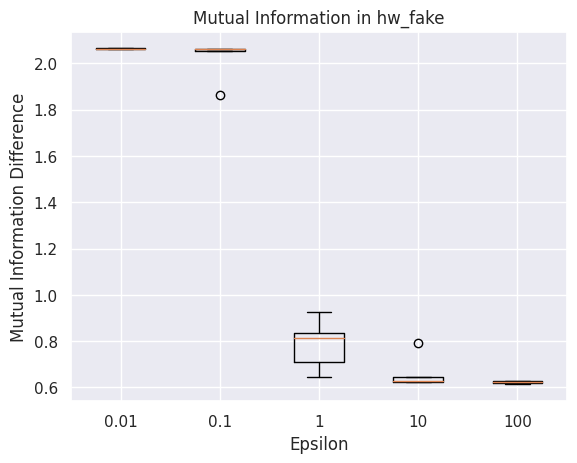

In [69]:
# Plot the distribution of KL-divergence scores
fig, ax = plt.subplots()
ax.boxplot(mi_fake, labels=epsilons_mst_mi)
ax.set_xlabel('Epsilon')
ax.set_ylabel('Mutual Information Difference')
ax.set_title('Mutual Information in hw_fake')
plt.show()

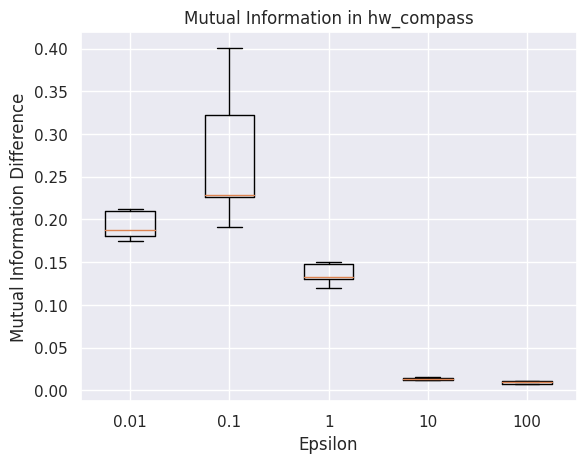

In [63]:
# Plot the distribution of KL-divergence scores
fig, ax = plt.subplots()
ax.boxplot(mi_compass, labels=epsilons_mst_mi)
ax.set_xlabel('Epsilon')
ax.set_ylabel('Mutual Information Difference')
ax.set_title('Mutual Information in hw_compass')
plt.show()